## Portfolio Analysis

In the following report we'll run through an analysis of Sector and Industry ETF's, performing some basic EDA, and then creating and optimizing a portfolio based off of those assets. 

We end by training a basic Long Short-Term Memory RNN for the purpose of forecasting returns on our optimized portfolio. 

Our data is retrieved from Alpha Vantage. API key required. 

We'll begin by importing all necessary libraries. We've put our portfolio functions in data.py and the RNN functions in lstm.py.

In [1]:
# libraries for analysis
import numpy as np
import pandas as pd
from data import *
from lstm import *
from sklearn.preprocessing import MinMaxScaler

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# database allocation
import requests_cache

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="ticks")

requests_cache.install_cache('my-cache')

Using TensorFlow backend.


You need an API key to access Alpha Vantage's data. Create your own key file and path and sub in to achieve results.

In [2]:
keyfile = '../keys/alpha_vantage.txt' # alpha vantage requires an API key, which can be readily obtained
start_date = '2012-01-01' # we'll look at the last seven years of data, roughly
market=['SPY'] 
sector = ['XLK','XLV'] 
industry = ['XBI','XPH','XHS','XHE','XTL','XSD','XWEB','XTH','XSW'] 

key = read_key(keyfile)
sector_data = get_data(key, market+sector)
sector_df = create_df(sector_data, start_date, norm=True)

#### Technical indicators and EDA of Time Series Data
We begin our analysis by detailing and observing our data and also its source. We'll be making use of Alpha Vantage, The New York Times, and the US Federal Reserve for data purposes through either open APIs or web scraping technologies. Alpha Vantage, which gives access to over 20+ years of time series data through its open API [3], is particularly useful as they have not only all listed equities, but also crypto's, FX, and technical indicators that one could pull depending on the level of analysis they wished to perform. For our purposes, we'll be taking a look at the following 12 SPDR ETF's:

S&P 500, sym: SPY | Technology Sector, sym: XLK | Healthcare Sector, sym: XLV | Biotech Industry, sym: XBI | Pharmaceutical Industry, sym: XPH | Healthcare Services Industry, sym: XHS | Healthcare Equipment Industry, sym: XHE | Telecom Industry, sym: XTL | Semiconductor Industry, sym: XSD | Internet Industry, sym: XWEB | Tech Hardware Industry, sym: XTH | Computer Software Industry, sym: XSW

Note --  Alpha Vantage has a limit of 5 calls per minute (500/day) so there is a 12 second timer between calls

Plotting the market and sector ETFs first gives us a more complete macro view of what is going on, and provides insight into time periods in which anomolies may have occurred (think Brexit, elections, wars, etc.) that would affect the overall market trends. We've normalized the growth to better illustrate the relation between sector and market. A couple things to take note of:

1) We can see when the economy / market experienced shocks, specifically in the mid to late 2015 and late 2018. The 2018 shock is more recent, and we can attribute it to the stock market loss that accompanied the government shutdown over border wall funding. 2015 seems to have been a generally volatile year for all markets, with the S&P closing down .7% [4]. 

2) There are apparent trends in the popularity of sectors, and we can see how those change throughout the last 6-7 years. Healthcare, once the significant overachiever, has been surpassed this past year by Technology. Healthcare also seems more volatile, which could be attributed to the difficulty in valuating pharma and biotech companies, whose worth is forecasted based off of trials / grant proposals most of the time [5].

3) This chart clearly shows the power of passive investing and index funds / ETFs. The SPY ETF, the 'worst performing' asset out of our three, still shows an average growth of 175% over its value at the beginning of our analysis, The Healthcare and Tech ETF's are even better. One can see how wealth can grow by leaving it in a passive fund, especially if you incrementally increase your position over time. 

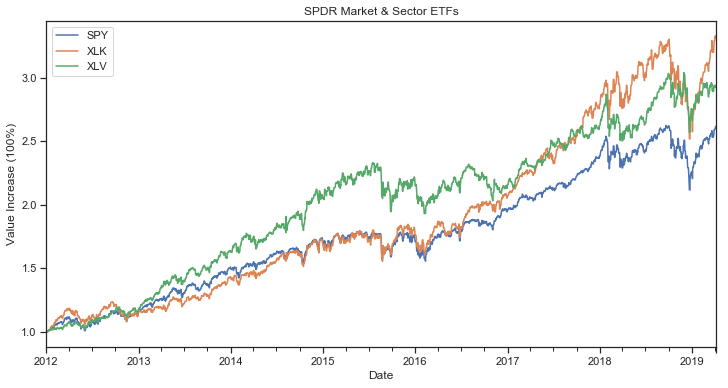

In [58]:
# we measure returns (relative) of market and sector ETF's
sector_df.plot(title='SPDR Market & Sector ETFs',figsize=(12,6))
plt.ylabel('Value Increase (100%)') # 3.0 refers to 3x or 300% returns
plt.xlabel('Date')
plt.show()

In [4]:
sector_df.describe()[1:]

,SPY,XLK,XLV
mean,1.759712,1.894074,2.010596
std,0.448392,0.648836,0.558824
min,1.000000,1.000000,0.995161
25%,1.424588,1.337969,1.552705
50%,1.739774,1.742181,2.124858
75%,2.125393,2.380151,2.401552
max,2.624539,3.329532,3.041039


We now introduce technical factors and the use of Bollinger Bands in the analysis of an asset. Technical analysis refers to the strategy of garnering statistical trends from gathered market data, generally stock price and volume. Bollinger Bands are a popular metric that plots an asset's moving average over a period of days, along with intervals equal to some scalar factor of the standard deviation. [6]

The idea behind the bands is that the day to day price movement breaking the upper bounds is a sign that the stock has hit a peak and one should sell, while a breach of the lower bounds would suggest the price is about to rise and one should buy. From the bands below, it seems like our healthcare ETF has been fairly volatile as of late, with what looks like a decenly sized upper breach around December of 2018, coindicing with the market downturn we saw in the previous graph.

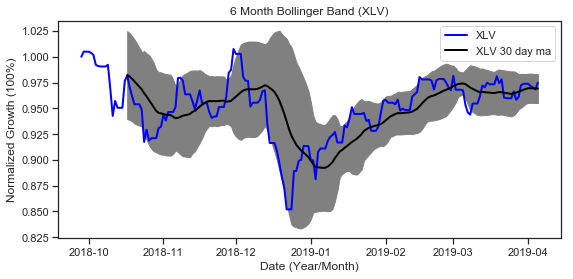

In [6]:
XLV_90 = sector_df[['XLV']][-190:]  # we'll compute a Bollinger Band for the Healthcare sector ETF
XLV_90 = bollinger(XLV_90)

fig,ax = plt.subplots(figsize=(9,4))

x_axis = XLV_90.index.get_level_values(0)
ax.fill_between(x_axis, XLV_90['XLV upper band'], XLV_90['XLV lower band'], color='grey')

ax.plot(x_axis, XLV_90['XLV'], color='blue', lw=2)
ax.plot(x_axis, XLV_90['XLV 30 day ma'], color='black', lw=2)

ax.set_title('6 Month Bollinger Band (XLV)')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Normalized Growth (100%)')
ax.legend()
plt.show()

Finally, a useful metric to have for any asset is whether it's correllated to the others in your portfolio. Generally, this is given by the Beta variable, though we did not obtain that for the purpose of this analysis. Generally, Beta measures how a particular asset will fair, given how he market fairs.

In our case, our three ETF's are very correlated, which makes sense as the sector ETF's are in essence contained in the market ETF (not perfectly but high multicolinearity). Diversifying our portfolio would be an ideal strategy to hedge against risk and bring down the volatility of our portfolio.

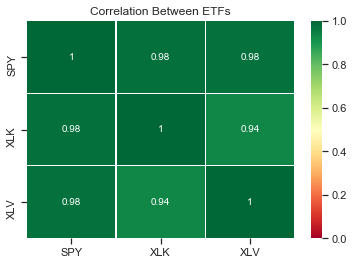

In [7]:
sns.heatmap(sector_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title('Correlation Between ETFs')
plt.show()

#### Efficient Portfolio Allocation

We next turn our attention to portfolio allocation, the Efficient Frontier, and the creation of an optimized portfolio based off of our ETFs above. A portfolio is a collection of assets that one invests in, assigning different weights to different assets depending on some pre-defined preference. In our analysis, we seek to maximize returns while minimizing risk (volatility). To achieve this, we optimize our allocation to maximize our portfolio's Sharpe Ratio: 

$$ Sharpe = \frac{Returns_{expected}-Risk Free Rate}{Volatility_{expected}}$$ 

Portfolio allocation theory deals with the question of how can we assign weights to our assets as to maximize returns for a given level of volatility. The Efficient Frontier is a visual representation of phenom. Every possible combination of risky assets can be plotted in the 'risk expected return space', the hyperbola. The upper edge of this hyperbola is the efficient frontier in the absence of a risk free asset. The line running tangent to the hyperbola represents the Capital Allocation Line, whose slope measures the additional return one receives from taking on more risk. [7] 

In [9]:
investment = 1000000
alist = [x+1 for x in range(len(industry))]
w0 = [x / np.sum(alist) for x in alist]

# create df and portfolio
industry_data = get_data(key, industry)
industry_df = create_df(industry_data, start_date)
portfolio, portfolio_statistics = create_portfolio(industry_df, investment, w0)

# normalize for clearer understanding of returns
norm_df = industry_df / industry_df.iloc[0,:]
norm_port = portfolio / portfolio[0]

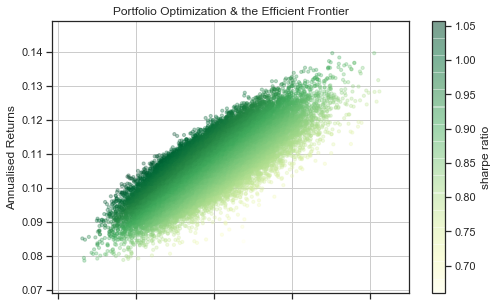

In [10]:
num_assets = len(industry)
num_port = 40000
ef = EF(industry_df, num_assets, num_port)

ef.plot.scatter(x='volatility', y='returns', c='sharpe ratio',
                cmap='YlGn', marker='o', s=10, alpha=0.3,
                   figsize=(8, 5), grid=True)

plt.title("Portfolio Optimization & the Efficient Frontier")
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Returns')
plt.show()

We construct a portfolio comprised of our ETF's and look at the difference in returns between them. It's apparent immediately that while our portfolio doesn't have the same performance as some of the industry ETF's, it doesn't suffer from the same volatility as said ETF's.

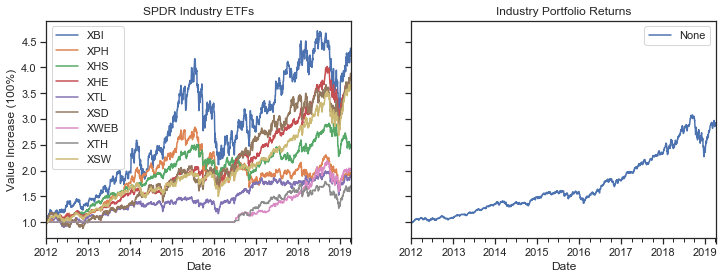

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
norm_df.plot(title='SPDR Industry ETFs',ax=ax[0])
ax[0].set_ylabel('Value Increase (100%)')
ax[0].set_xlabel('Date')

norm_port.plot(title='Industry Portfolio Returns',ax=ax[1],legend=True)
ax[1].set_ylabel('Returns (100%)')
ax[1].set_xlabel('Date')

plt.show()

We plot our portfolio returns against the sector and market funds to see a better idea of how the perform against a more 'stable' competitor. We can see that our optimization algorithm decided to only invest in 5 of the 9 stocks in our domain, to get a cumulative return of almost 2x.

cumulative returns: 1.919
average daily returns: 0.0
average daily standard dev: 0.007
sharpe ratio: 0.115
allocation: [0.    0.    0.    0.378 0.    0.025 0.189 0.211 0.198]


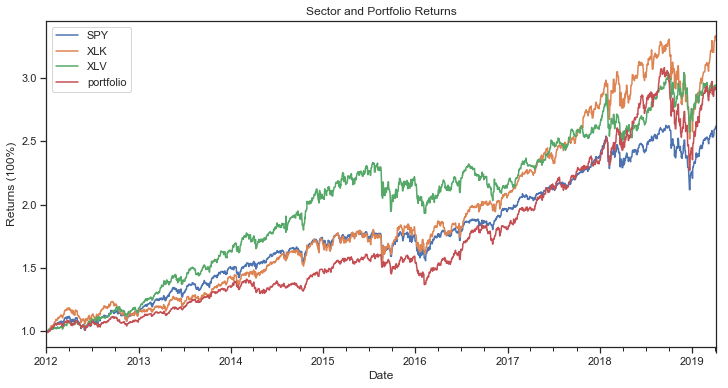

In [12]:
for key,value in portfolio_statistics.items():
    print("{}: {}".format(key, np.around(value,3)))

port_df = norm_port.to_frame(name='portfolio')
df = sector_df.merge(port_df,left_index=True, right_index=True)

df.plot(title='Sector and Portfolio Returns', figsize=(12,6))
plt.ylabel('Returns (100%)')
plt.xlabel('Date')
plt.show()

Our portfolio performance can hinge on how diversified we are. We made note of how that was lacking in the sector and market analysis. Here, it seems that most of the assets are correlated with one another, which is in line with our thinking as we're taking industries from the same sector. There are a couple that seem to be fairly uncorrelated though which may give us an idea of types of companies to include next time to diversify even more.

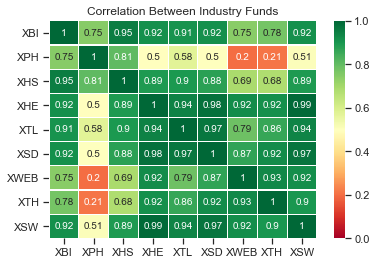

In [13]:
sns.heatmap(industry_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.title('Correlation Between Industry Funds')
plt.show()

__LSTM Training__

We look for a method by which we can accurately forecast portfolio returns, turning to Neural Networks. Recurrent Neural Networks (RNNs) are used for the analysis of sequential data (time series data). The Long Short-Term Memory RNN has an advantage over general RNN's as it has the ability to retain informatino from previous layers (feedback connection). 

We'll run a basic initial LSTM, then run a more efficient model based off of the results from our first, as well as a grid search function to find parameteers associated with the lowest RMSE.

In [33]:
test_size = .30
scale = MinMaxScaler(feature_range=(-1,1)) # range corresponds to that of tanh
train_set, test_set = train_test_split(portfolio, test_size) # custom function to split time series data

# Our input needs to be in the format of NxM matrices
train_scaled = scale.fit_transform(train_set.values.reshape(-1,1))
test_scaled = scale.fit_transform(test_set.values.reshape(-1,1))
test_x, test_y = lstm_dataset(test_scaled, timestep=5) # default is 1 timestep, 1 feature

# package data and params
data = [train_scaled, test_scaled]
param_base = [5,30,100,32,1] # inputs, nodes, epochs, batch size, features
# fit and predict 
lstm, history = fit_model(data, param_base)
pred = lstm.predict(test_x)

# calculate RMSE
prediction = scale.inverse_transform(pred)
test_y_inv = scale.inverse_transform(test_y.reshape(-1,1))
root_mse = rmse(test_y, prediction)

We can see initially that our prediction is fairly far off of our portfolio returns, even considering the fact that it is not normalized. a loss of 2+ million needs to be reduced! We can get some insight from our loss per epoch though. The loss isn't decreasing with the number of epochs after a very fast initial decrease. 

In [ ]:
# plot our forecast against test data, and take a look at our MSE
real_price = portfolio[-test_y_inv.shape[0]:].to_frame().rename({0:'Actual Returns'},axis=1)
pred_price = pd.DataFrame(prediction,index=real_price.index).rename({0:'Forecast Returns'},axis=1)
df = real_price.merge(pred_price, left_index=True, right_index=True)

# we also have the mean squared error
print("Model RMSE of {}".format(round(root_mse,3)))

fig, ax = plt.subplots(1,2,figsize=(12,4))

df.plot(title='Actual vs. Forecasted Returns',ax=ax[0])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns (USD)')

ax[1].plot(history.history['loss'],color='red')
ax[1].plot(history.history['val_loss'],color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(labels=['Training Loss','Validation Loss'])
plt.show()

Ww run our model again, with more efficient parameters.

In [56]:
param_best = [5, 100,5,32,1]
# fit and predict 
lstm, history = fit_model(data, param_best)
pred = lstm.predict(test_x)

# calculate RMSE
prediction = scale.inverse_transform(pred)
test_y_inv = scale.inverse_transform(test_y.reshape(-1,1))
root_mse = rmse(test_y_inv, prediction)

We can see a drastic improvement in our model, with the RMSE dropping from 2+ million to approximately 37 thousand. 

While still large, remember that our initial investment was 1 million. We look to the LSTM as a tool for general trends rather than as a means for predicting the actual return. 

Model RMSE of 37735.038


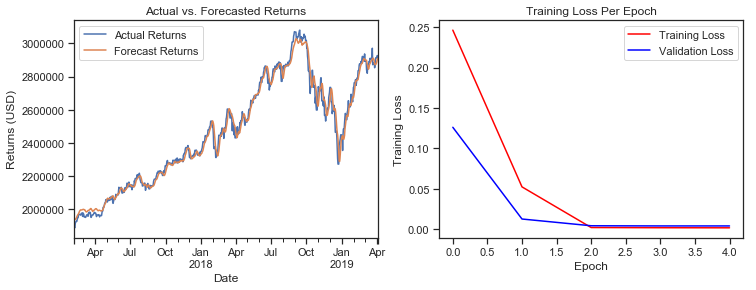

In [57]:
# plot our forecast against test data, and take a look at our MSE
real_price = portfolio[-test_y_inv.shape[0]:].to_frame().rename({0:'Actual Returns'},axis=1)
pred_price = pd.DataFrame(prediction,index=real_price.index).rename({0:'Forecast Returns'},axis=1)
df = real_price.merge(pred_price, left_index=True, right_index=True)

# we also have the mean squared error
print("Model RMSE of {}".format(round(root_mse,3)))

fig, ax = plt.subplots(1,2,figsize=(12,4))

df.plot(title='Actual vs. Forecasted Returns',ax=ax[0])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Returns (USD)')

ax[1].plot(history.history['loss'],color='red')
ax[1].plot(history.history['val_loss'],color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(labels=['Training Loss','Validation Loss'])